# ML703 Project: Probabilistic Air Quality Forecasting with Bayesian Inference

**Team Members**: Muhra AlMahri, Ayesha Alhammadi  
**Dataset**: Hourly PM2.5 Air Quality Data (India)  
**Goal**: Compare traditional ARIMA with Bayesian models (BSTS and GPR) for uncertainty-aware forecasting.

In [ ]:
!pip install pymc arviz --quiet
!pip install scikit-learn --quiet
!pip install properscoring

In [ ]:
# Imports
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
import properscoring as ps
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

sns.set(style='whitegrid')

## 1. Data Preprocessing

In [ ]:
# Load the data
df = pd.read_csv('/content/air-quality-india 1.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df = df.asfreq('H')  # Set frequency to hourly
df['PM2.5'].interpolate(method='time', inplace=True)
daily_pm25 = df['PM2.5'].resample('D').mean()

<ipython-input-3-d8d268b960ee>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')  # Set frequency to hourly
<ipython-input-3-d8d268b960ee>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PM2.5'].interpolate(method='time', inplace=True)


## 2. Baseline Model: SARIMA

In [ ]:
data_subset = daily_pm25[-200:]
train = data_subset[:-45]
test = data_subset[-45:]

In [ ]:
train_data = daily_pm25[:-100]
test_data = daily_pm25[-100:]

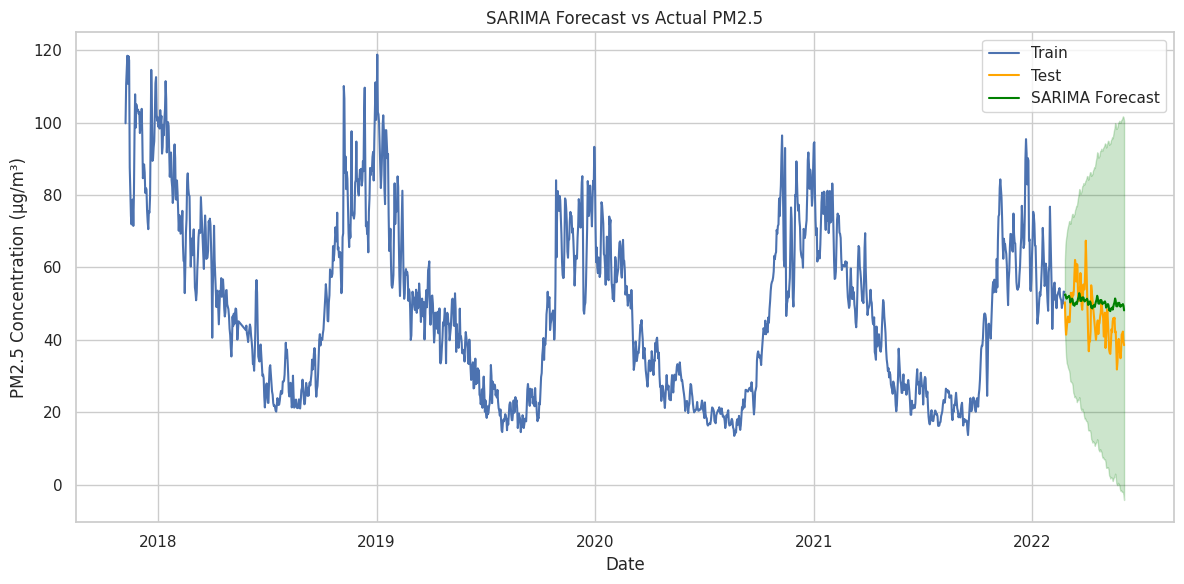

In [ ]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_1= SARIMAX(train_data,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 30),  # Monthly pattern
                enforce_stationarity=False,
                enforce_invertibility=False)

results_1 = model_1.fit(disp=False)

# Forecast
forecast_obj_1 = results_1.get_forecast(steps=len(test_data))
forecast_mean_1 = forecast_obj_1.predicted_mean
conf_int_1 = forecast_obj_1.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test', color='orange')
plt.plot(forecast_mean_1.index, forecast_mean_1, label='SARIMA Forecast', color='green')
plt.fill_between(forecast_mean_1.index, conf_int_1.iloc[:, 0], conf_int_1.iloc[:, 1], color='green', alpha=0.2)
plt.title("SARIMA Forecast vs Actual PM2.5")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()

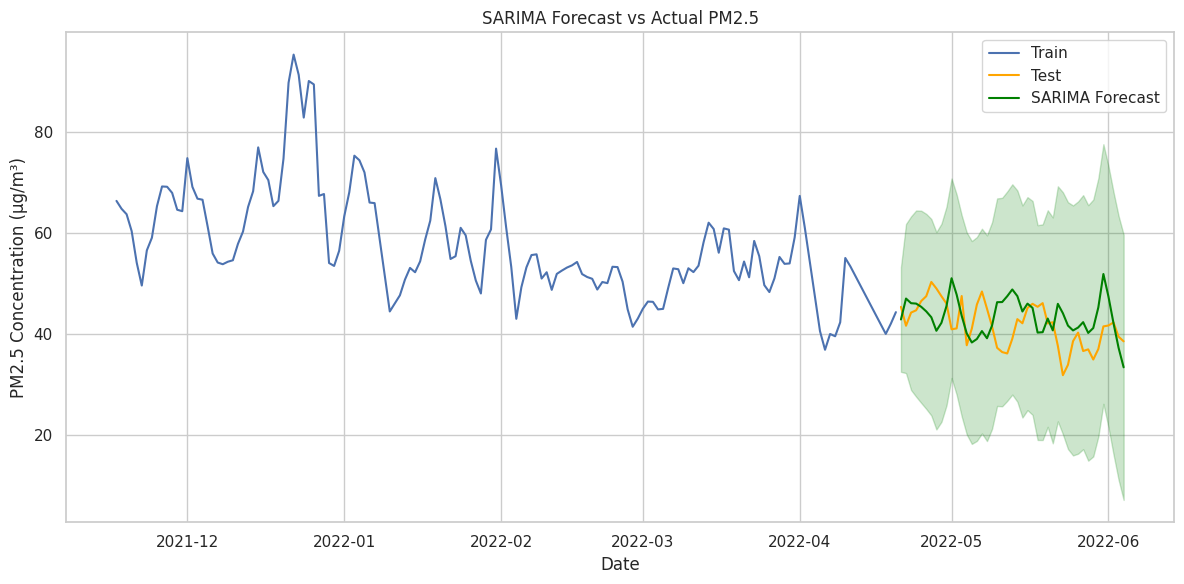

In [ ]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 30),  # Monthly pattern
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Forecast
forecast_obj = results.get_forecast(steps=len(test))
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title("SARIMA Forecast vs Actual PM2.5")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Bayesian Structural Time Series (BSTS)

*Placeholder for PyMC3 or PyStan implementation of BSTS.*

In [ ]:
# 📦 Install PyMC and dependencies (first cell in Colab)
!pip install pymc arviz --quiet

Output()

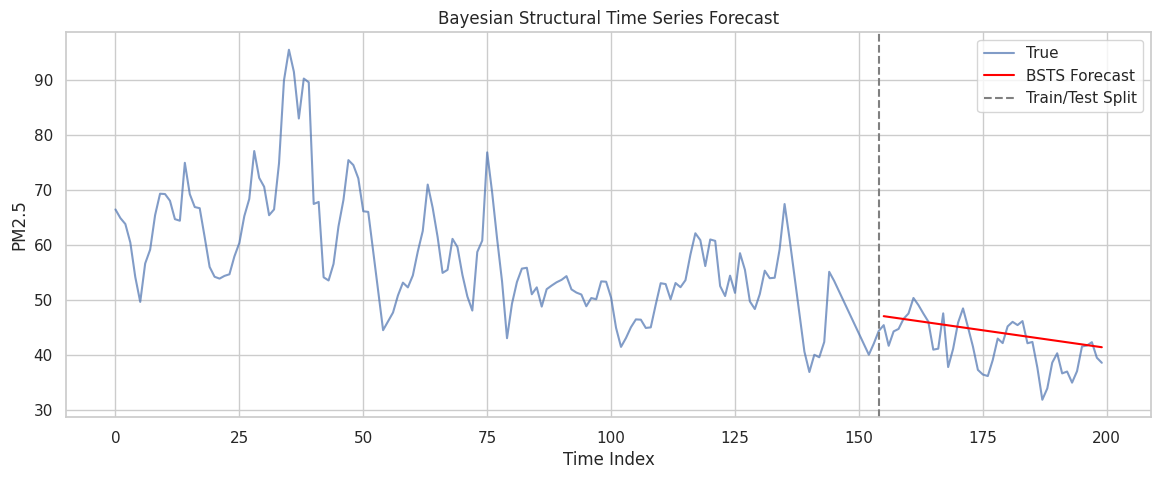

/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'seasonality'}>,
        <Axes: title={'center': 'seasonality'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

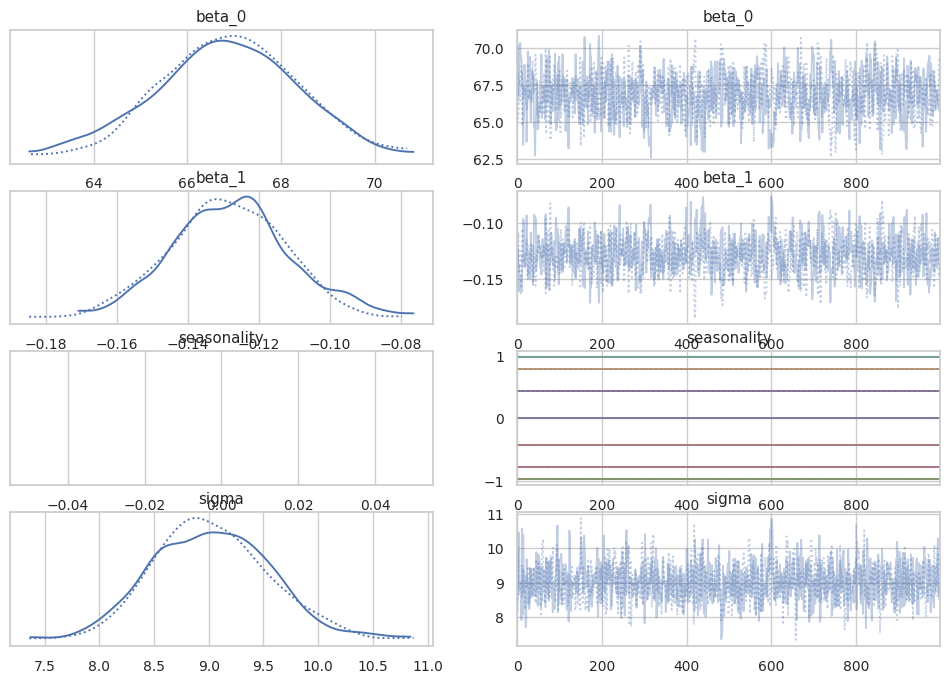

In [ ]:

# ✂️ Use last 200 days for modeling
y = daily_pm25[-200:].values
t = np.arange(len(y))
y_train = y[:-45]
t_train = t[:-45]
t_test = t[-45:]

# 🧠 PyMC model: Bayesian time-trend regression

with pm.Model() as bsts_model:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Add seasonal component (e.g., weekly seasonality)
    seasonality = pm.Deterministic("seasonality",
                                  pm.math.sin(2 * np.pi * t_train / 7)) # Wrap np.sin with pm.math.sin

    # Update mu to include seasonality
    mu = beta_0 + beta_1 * t_train + seasonality

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)

# 🔍 Posterior predictive for test time
# Directly compute forecast using mean posterior estimates
beta_0_mean = trace.posterior["beta_0"].mean().values
beta_1_mean = trace.posterior["beta_1"].mean().values
forecast = beta_0_mean + beta_1_mean * t_test
forecast = trace.posterior["beta_0"].mean().values + trace.posterior["beta_1"].mean().values * t_test

# 📊 Plot
plt.figure(figsize=(14,5))
plt.plot(t, y, label="True", alpha=0.7)
plt.plot(t_test, forecast, label="BSTS Forecast", color='red')
plt.axvline(x=t_train[-1], color='gray', linestyle='--', label="Train/Test Split")
plt.title("Bayesian Structural Time Series Forecast")
plt.xlabel("Time Index")
plt.ylabel("PM2.5")
plt.legend()
plt.show()

# 📈 Optional: Inference diagnostics
az.plot_trace(trace)

## 4. Gaussian Process Regression (GPR)

*Placeholder for implementation using `scikit-learn` or `GPy`.*

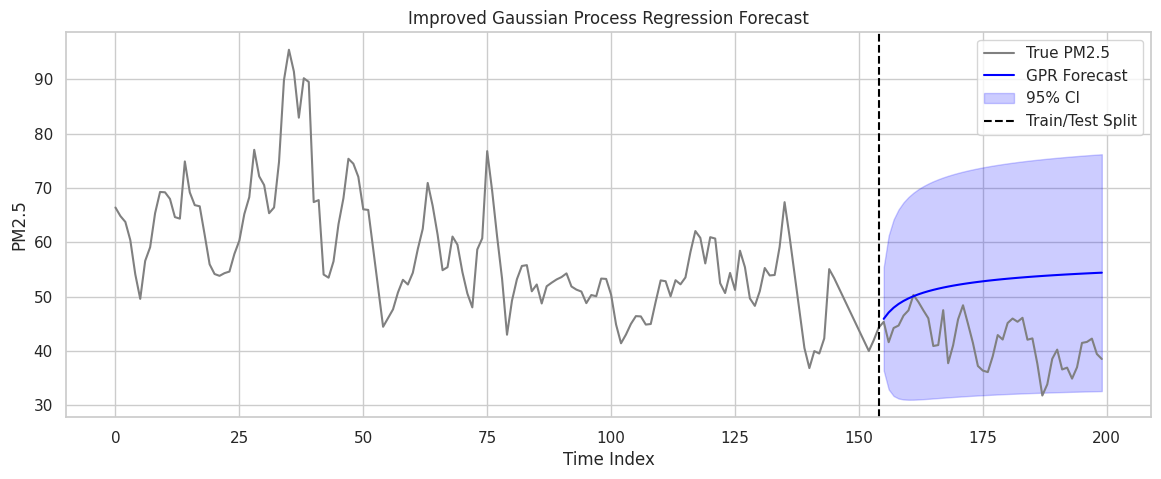

In [ ]:
# 📚 Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

# 🧪 Use last 200 days
y = daily_pm25[-200:].values
X = np.arange(len(y)).reshape(-1, 1)

X_train = X[:-45]
y_train = y[:-45]
X_test = X[-45:]
y_true = y[-45:]

# 📏 Normalize X values (GPR is sensitive to scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔧 Kernel: Flexible with RationalQuadratic
kernel = C(1.0, (1e-2, 1e2)) * RationalQuadratic(length_scale=1.0, alpha=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# 🧠 Fit and predict
gpr.fit(X_train_scaled, y_train)
y_pred, sigma = gpr.predict(X_test_scaled, return_std=True)

# 📊 Plot with 95% CI
plt.figure(figsize=(14, 5))
plt.plot(X, y, label="True PM2.5", color="gray")
plt.plot(X_test, y_pred, label="GPR Forecast", color="blue")
plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                 alpha=0.2, color="blue", label="95% CI")
plt.axvline(X_train[-1], color="black", linestyle="--", label="Train/Test Split")
plt.title("Improved Gaussian Process Regression Forecast")
plt.xlabel("Time Index")
plt.ylabel("PM2.5")
plt.legend()
plt.show()

## 5. Evaluation Metrics

> Add blockquote



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define BSTS forecast
beta_0_mean = trace.posterior["beta_0"].mean().values
beta_1_mean = trace.posterior["beta_1"].mean().values
forecast_bsts = beta_0_mean + beta_1_mean * t_test
forecast_bsts = np.asarray(forecast_bsts).flatten()

# Ensure all forecasts are numpy arrays
X_test = np.arange(len(y) - 45, len(y)).reshape(-1, 1)
forecast_sarima = np.asarray(forecast_mean[-45:]).flatten()
y_pred = np.asarray(y_pred).flatten()  # GPR
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Ground truth
y_true = y[-45:]

# RMSE and MAE
rmse_sarima = np.sqrt(mean_squared_error(y_true, forecast_sarima))
mae_sarima = mean_absolute_error(y_true, forecast_sarima)

rmse_gpr = np.sqrt(mean_squared_error(y_true, y_pred))
mae_gpr = mean_absolute_error(y_true, y_pred)

rmse_bsts = np.sqrt(mean_squared_error(y_true, forecast_bsts))
mae_bsts = mean_absolute_error(y_true, forecast_bsts)

# Print results
print("Model Evaluation Metrics (Test Set - Last 45 Days):\n")
print(f"SARIMA  → RMSE: {rmse_sarima:.2f}, MAE: {mae_sarima:.2f}")
print(f"GPR    → RMSE: {rmse_gpr:.2f}, MAE: {mae_gpr:.2f}")
print(f"BSTS   → RMSE: {rmse_bsts:.2f}, MAE: {mae_bsts:.2f}")

Model Evaluation Metrics (Test Set - Last 45 Days):

SARIMA  → RMSE: 6.01, MAE: 4.98
GPR    → RMSE: 16.00, MAE: 15.39
BSTS   → RMSE: 4.36, MAE: 3.44
